In [1]:
%matplotlib inline

import matplotlib
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimage
import cv2
import numpy as np

In [2]:
# Check the algorithm on different test images
test_image='../test_images/test4.jpg'

Image size: (720, 1280, 3)


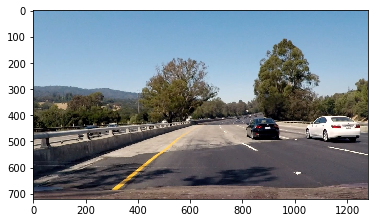

In [3]:
# OpenCV reads in BGR format by default
image=cv2.cvtColor(cv2.imread(test_image),cv2.COLOR_BGR2RGB)
plt.imshow(image)
print("Image size: {}".format(image.shape))

Experiment on top and bottom threshold and Show the threshold rectangle:

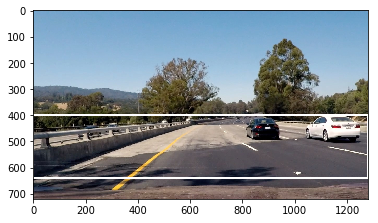

In [4]:
detection_area=((0,400),(1280,640))
detection_rect=np.copy(image)
plt.imshow(cv2.rectangle(detection_rect,detection_area[0],detection_area[1], color=(255,255,255),thickness=5))

Observing the image above, we can assume that cars far away look smaller and the close ones look larger. Likewise, we can set different thresholds for 64x64, 128x128 windows

In [5]:
overlap=0.3 #70% overlap b/n windows
window_sizes=[64,96,128,220]
slide_thresholds=[(310,310+4*64//2),(310,310+3*96//2),(300,300+3*128//2),(280,280+2*220//2)]

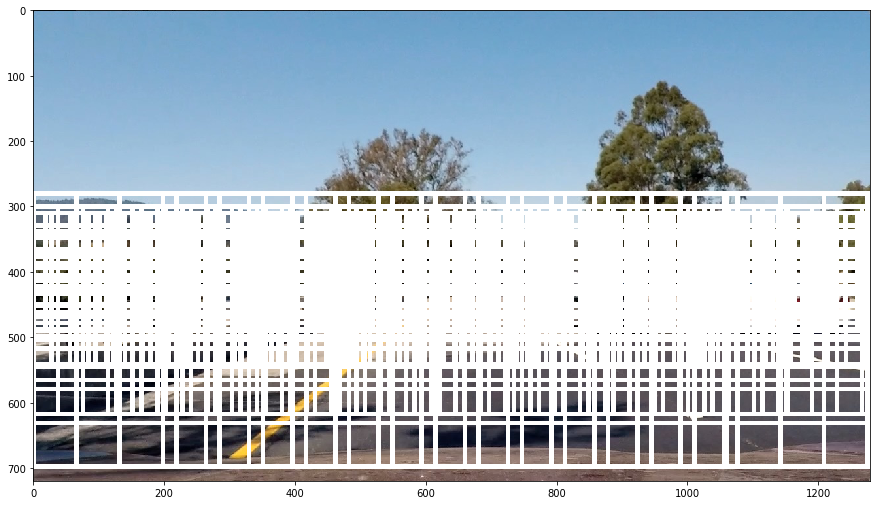

In [6]:
# Show the windows on a test image
windows=np.copy(image)
windos_rects=[]
for i in range(len(window_sizes)):
    window_size = window_sizes[i]
    color=np.random.randint(0,255,size=(3,)).astype(np.float64)
    for row in range(slide_thresholds[i][0],slide_thresholds[i][1],int(window_size*overlap)):
        for col in range(0,image.shape[1]-window_size,int(window_size*overlap)):
            cv2.rectangle(windows,(col,row),(col+window_size-1,row+window_size-1),(255,255,255),thickness=5)
            windos_rects.append(((col,row),(col+window_size-1,row+window_size-1)))
#         Handle the last window column
        cv2.rectangle(windows,(image.shape[1]-window_size,row),(image.shape[1]-1,row+window_size-1),(255,255,255),5)
        windos_rects.append(((image.shape[1]-window_size,row),(image.shape[1]-1,row+window_size-1)))
fig=plt.figure(figsize=(15,10))
plt.imshow(windows)

Run SVM on windows

In [7]:
from sklearn import svm
from sklearn.externals import joblib
from sklearn.preprocessing import StandardScaler

In [8]:
model=joblib.load('model_svm4.pkl')
scaler=joblib.load('stdscaler4.pkl')

In [9]:
from skimage.feature import hog
def bin_spatial(img, size=(16, 16)):
    # Use cv2.resize().ravel() to create the feature vector
    features = cv2.resize(img, size).ravel() 
    # Return the feature vector
    return features

def color_hist(img, nbins=16, bins_range=(0, 256)):
    # Compute the histogram of the color channels separately
    channel1_hist = np.histogram(img[:,:,0], bins=nbins, range=bins_range)
    channel2_hist = np.histogram(img[:,:,1], bins=nbins, range=bins_range)
    channel3_hist = np.histogram(img[:,:,2], bins=nbins, range=bins_range)
    # Concatenate the histograms into a single feature vector
    hist_features = np.concatenate((channel1_hist[0], channel2_hist[0], channel3_hist[0]))
    # Return the individual histograms, bin_centers and feature vector
    return hist_features

def get_features(img,cell_per_block=2,pix_per_cell=16,orient=11, color_hist_bins=16, img_resize=(64,64)):
    if(img.shape[0]!=img_resize[0]):
        img=cv2.resize(img,img_resize)
#     returns the feature vector for the image
    yuv_image=cv2.cvtColor(img, cv2.COLOR_RGB2YUV)
    feat1=hog(yuv_image[:,:,0], orientations=orient, pixels_per_cell=(pix_per_cell, pix_per_cell), cells_per_block=(cell_per_block, cell_per_block), visualise=False, feature_vector=True)
    feat2=hog(yuv_image[:,:,0], orientations=orient, pixels_per_cell=(pix_per_cell, pix_per_cell), cells_per_block=(cell_per_block, cell_per_block), visualise=False, feature_vector=True)
    feat3=hog(yuv_image[:,:,0], orientations=orient, pixels_per_cell=(pix_per_cell, pix_per_cell), cells_per_block=(cell_per_block, cell_per_block), visualise=False, feature_vector=True)
#    get spacial features
    return np.concatenate((feat1,feat2,feat3,bin_spatial(img),color_hist(img)))

In [10]:
test_image='../test_images/test4.jpg'

detection_image=np.copy(cv2.cvtColor(cv2.imread(test_image),cv2.COLOR_BGR2RGB))
X_feat=[]
for _win in windos_rects:
    _img=np.copy(detection_image[_win[0][1]:_win[1][1]+1, _win[0][0]:_win[1][0]+1,:])
#     Get the features
    X_feat.append(scaler.transform(get_features(_img).reshape(1,-1)))

In [11]:
n_feats=X_feat[0].shape[-1]
X_feat=np.array(X_feat).reshape(-1,n_feats)
probs=model.decision_function(X_feat)

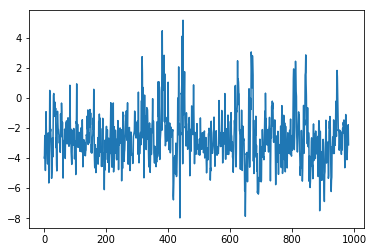

In [12]:
plt.plot(np.arange(X_feat.shape[0]),probs)

In [13]:
preds=model.predict(X_feat)

1.87493151916


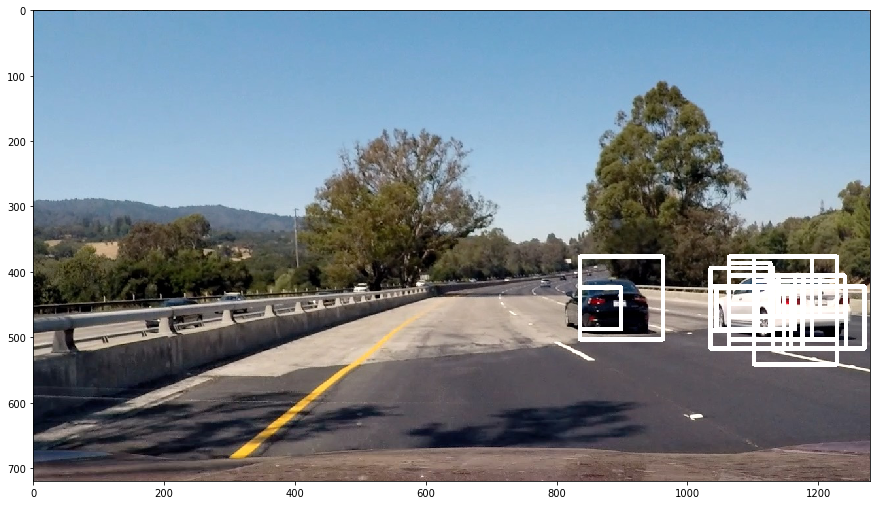

In [14]:
pred_threshold=np.max(probs)-(np.max(probs)-np.min(probs))/4
print(pred_threshold)
for (_win,pred) in zip(windos_rects,probs):
    if pred > pred_threshold:
        cv2.rectangle(detection_image,_win[0],_win[1],(255,255,255),5)
fig=plt.figure(figsize=(15,10))
plt.imshow(detection_image)

In [15]:
# Multiple detection and false positive handling
from scipy.ndimage.measurements import label

def add_heat(heatmap, bbox_list):
    # Iterate through list of bboxes
    for box in bbox_list:
        # Add += 1 for all pixels inside each bbox
        # Assuming each "box" takes the form ((x1, y1), (x2, y2))
        heatmap[box[0][1]:box[1][1], box[0][0]:box[1][0]] += 1

    # Return updated heatmap
    return heatmap

def apply_threshold(heatmap, threshold):
    # Zero out pixels below the threshold
    heatmap[heatmap <= threshold] = 0
    # Return thresholded map
    return heatmap

def get_bboxlist(img):
    bboxlist=[]
    detection_image=np.copy(img)
    X_feat=[]
    for _win in windos_rects:
        _img=np.copy(detection_image[_win[0][1]:_win[1][1]+1, _win[0][0]:_win[1][0]+1,:])
    #     Get the features
        X_feat.append(scaler.transform(get_features(_img).reshape(1,-1)))
    n_feats=X_feat[0].shape[-1]
    X_feat=np.array(X_feat).reshape(-1,n_feats)
    preds=model.decision_function(X_feat)
    pred_threshold=np.max(preds)-(np.max(preds)-np.min(preds))/4
    for (_win,pred) in zip(windos_rects,preds):
        if pred > 1.5:
            bboxlist.append(((_win[0][0],_win[0][1]),(_win[1][0],_win[1][1])))
#             cv2.rectangle(detection_image,_win[0],_win[1],(255,255,255),5)
    return bboxlist

def draw_labeled_bboxes(img, labels):
    # Iterate through all detected cars
    for car_number in range(1, labels[1]+1):
        # Find pixels with each car_number label value
        nonzero = (labels[0] == car_number).nonzero()
        # Identify x and y values of those pixels
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        # Define a bounding box based on min/max x and y
        bbox = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))
        # Draw the box on the image
        cv2.rectangle(img, bbox[0], bbox[1], (0,0,255), 6)
    # Return the image
    return img


2 cars found


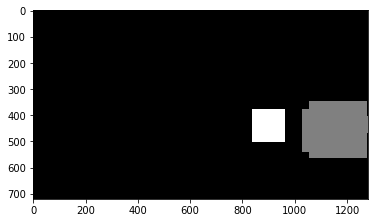

In [16]:
import matplotlib.image as mpimg
_image = mpimg.imread('../test_images/test4.jpg')
heatmap = np.zeros_like(_image[:,:,0]).astype(np.float)


bbox_list=get_bboxlist(_image)
heatmap = add_heat(heatmap,bbox_list)
heatmap = apply_threshold(heatmap, 0)
labels = label(heatmap)
print(labels[1], 'cars found')
plt.imshow(labels[0], cmap='gray')

In [17]:
from collections import deque
from functools import reduce
heatmaps=deque(maxlen=10)

In [18]:
# New video processing algorithm for removing false positives &
# handling multiple detections:
def process_video(frame):
    global heatmap, heatmaps
#     Assumes a rgb frame to be passed
    bbox_list=get_bboxlist(frame)
    heatmaps.append(add_heat(np.zeros_like(frame[:,:,0]).astype(np.float),bbox_list))
    heatmap = apply_threshold(reduce(lambda x,y: x + y, heatmaps), 12)
    labels = label(heatmap)
#     print(labels[1], 'cars found')
#     plt.imshow(labels[0], cmap='gray')
    return draw_labeled_bboxes(frame, labels)
#     return labels[0]


In [19]:
# Test on video;
from moviepy.editor import VideoFileClip
clip1 = VideoFileClip("../project_video.mp4")
white_clip = clip1.fl_image(process_video) #NOTE: this function expects color images!!
out_file="submission2.mp4"
%time white_clip.write_videofile(out_file, audio=False)


[MoviePy] >>>> Building video submission2.mp4
[MoviePy] Writing video submission2.mp4


100%|█████████▉| 1260/1261 [41:39<00:01,  1.98s/it]


[MoviePy] Done.
[MoviePy] >>>> Video ready: submission2.mp4 

CPU times: user 41min 57s, sys: 7min 16s, total: 49min 14s
Wall time: 41min 39s


In [20]:
from IPython.display import HTML

HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(out_file))

Reflections:

Looking at this video, there are still some frames where the cars are not detected. But one main thing to note is that, Feature vector size ~2000 has slowed down the pipeline.

For this run, I have used Linear SVM model with following features:

- HOG with:
    - cell_per_block=2
    - pix_per_cell=16
    - orient=11
    - color_hist_bins=16
    - img_resize=(64,64)
- Spatial binning of YUV channels


One very important thing to note is that, I have used `decision_function` from LinearSVM and applied threshold on that output to better classify the results. This helped me improve my results.
